In [1]:
%matplotlib inline

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

import os
import time
import csv
import shelve
from datetime import datetime

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib import cm

np.random.seed(0)

In [2]:
FTRAIN = './Data/FKD_Train.csv'
FTEST = './Data/FKD_Test.csv'

def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

#     print(df.count())  # prints the number of values for each column
#     df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        # scale target coordinates to [-1, 1] - need because we don't have bias on the net
        y = (y - 48) / 48  # 96/2=48
#         X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
    else:
        y = None

    return X, y, np.array(df.columns[:-1])

X, y, y_name = load()
X_t, trash, junk = load(test=True)
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))
print("X_t.shape == {}; X_t.min == {:.3f}; X_t.max == {:.3f}".format(X_t.shape, X_t.min(), X_t.max()))

X.shape == (7049, 9216); X.min == 0.000; X.max == 1.000
y.shape == (7049, 30); y.min == nan; y.max == nan
X_t.shape == (1783, 9216); X_t.min == 0.000; X_t.max == 1.000


check images with same training keypoints

In [57]:
X_group, y_group = {}, {}
i = 0
for x,f in zip(X,y):    
    picker = ~np.isnan(f)
    id = str.join(',', y_name[picker])
    if id not in X_group:
        X_group[id] = []
        y_group[id] = []
    X_group[id].append(x)
    y_group[id].append(f[picker])
    
feature_size = np.array([np.array(x[1]).shape for x in y_group.items()]) 
big_group = feature_size[:,0].argsort()

X1 = np.reshape(X_group.items()[big_group[-1]][1], (-1, 1, 96, 96))
X2 = np.reshape(X_group.items()[big_group[-2]][1], (-1, 1, 96, 96))
y1 = np.array(y_group.items()[big_group[-1]][1])
y2 = np.array(y_group.items()[big_group[-2]][1])
feature1 = y_group.keys()[big_group[-1]].split(',')
feature2 = y_group.keys()[big_group[-2]].split(',')
x_t = np.reshape(X_t, (-1, 1, 96, 96))

print '1st training set: X1:%s - y1:%s, y1.min:%.3f, y1.max:%.3f' %(str(X1.shape), str(y1.shape), y1.min(), y1.max())
print '2nd training set: X2:%s - y2:%s, y2.min:%.3f, y2.max:%.3f' %(str(X2.shape), str(y2.shape), y2.min(), y2.max())
print 'testing set: x_t:%s' %str(x_t.shape)
n_top = 7
print '\nimages # vs. features # for top %d groups:' %n_top
print feature_size[big_group][-n_top:]

1st training set: X1:(4755, 1, 96, 96) - y1:(4755, 8), y1.min:-0.986, y1.max:0.988
2nd training set: X2:(2140, 1, 96, 96) - y2:(2140, 30), y2.min:-0.920, y2.max:0.996
testing set: x_t:(1783, 1, 96, 96)

images # vs. features # for top 7 groups:
[[   6   26]
 [  10    6]
 [  13   28]
 [  26   28]
 [  31   28]
 [2140   30]
 [4755    8]]


Plotting test

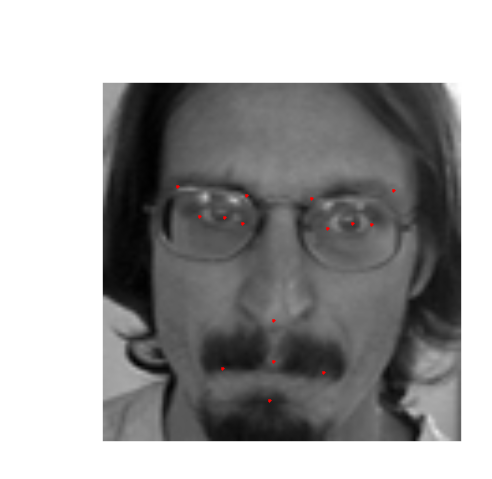

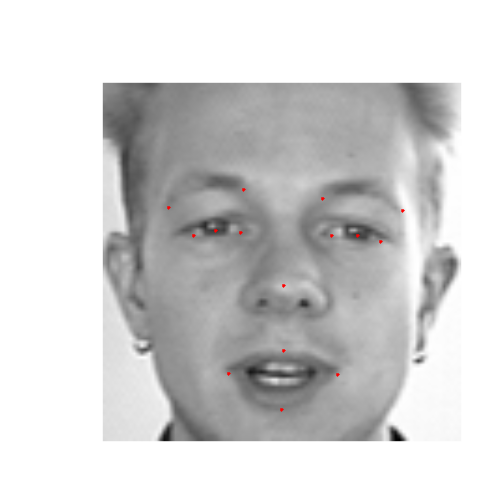

In [62]:
def plot(image, points, pred=[]):
    # print a picture to see
    plt.figure(figsize=(8, 8))
    if len(image)==96:
        plt.imshow(image, cmap = cm.gray)
    else:
        plt.imshow(np.reshape(image,(96,96)), cmap = cm.gray)
    plt.axis('off')
    if len(points)>0:
        for i in range(len(points)/2):
            plt.plot(points[2*i], points[2*i+1],'r.')
    if len(pred)>0:
        for i in range(len(pred)/2):
            plt.plot(pred[2*i],pred[2*i+1],'c.')

# testing example    
ranges = [np.ptp(x) for x in X2]
id = np.argsort(ranges)[-12]
plot(X2[0], 48*y2[0]+48)
plot(X2[id], 48*y2[id]+48)

train a convonet for 1st group training set

In [5]:
net1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=y1.shape[1], output_nonlinearity=None,

    update_learning_rate=0.02,
    update_momentum=0.9,
    
    regression=True,
    max_epochs=30,
    verbose=1,
    )

net1.fit(X1, y1)

  input             	(None, 1, 96, 96)   	produces    9216 outputs
  conv1             	(None, 32, 94, 94)  	produces  282752 outputs
  pool1             	(None, 32, 47, 47)  	produces   70688 outputs
  conv2             	(None, 64, 46, 46)  	produces  135424 outputs
  pool2             	(None, 64, 23, 23)  	produces   33856 outputs
  conv3             	(None, 128, 22, 22) 	produces   61952 outputs
  pool3             	(None, 128, 11, 11) 	produces   15488 outputs
  hidden4           	(None, 500)         	produces     500 outputs
  hidden5           	(None, 500)         	produces     500 outputs
  output            	(None, 8)           	produces       8 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -------
      1       0.01655       0.00784      2.11177  571.42s
      2       0.00807       0.00703      1.14848  559.06s
      3       0.00752       0.00662      1.13604  548.71s
      4       0.00720       0.00636      1.1

/Users/leiyang/src/lasagne/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "


NeuralNet(X_tensor_type=<function tensor4 at 0x109c18c08>,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10b32f790>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10b177a50>,
     conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_score=None,
     eval_size=0.2, hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=30, more_params={},
     objective=<class 'lasagne.o

In [49]:
net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    # 3 convoluational layer
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    # 2 fully connected hidden layer
    hidden4_num_units=500, hidden5_num_units=500,
    # fully connected output layer, no activation function to give continuous output
    output_num_units=y2.shape[1], output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,
    
    regression=True,
    max_epochs=30,
    verbose=1,
    )

net2.fit(X2, y2)

  input             	(None, 1, 96, 96)   	produces    9216 outputs
  conv1             	(None, 32, 94, 94)  	produces  282752 outputs
  pool1             	(None, 32, 47, 47)  	produces   70688 outputs
  conv2             	(None, 64, 46, 46)  	produces  135424 outputs
  pool2             	(None, 64, 23, 23)  	produces   33856 outputs
  conv3             	(None, 128, 22, 22) 	produces   61952 outputs
  pool3             	(None, 128, 11, 11) 	produces   15488 outputs
  hidden4           	(None, 500)         	produces     500 outputs
  hidden5           	(None, 500)         	produces     500 outputs
  output            	(None, 30)          	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -------
      1       0.11732       0.05553      2.11262  235.69s
      2       0.02256       0.00903      2.49780  239.64s
      3       0.00818       0.00741      1.10397  277.94s
      4       0.00679       0.00667      1.0

NeuralNet(X_tensor_type=<function tensor4 at 0x10a28e6e0>,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10b238590>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10b225850>,
     conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_score=None,
     eval_size=0.2, hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=30, more_params={},
     objective=<class 'lasagne.o

Predict and assemble result to generate submission file

In [8]:
# start_time = time.time()
# y_hat2 = net2.predict(x_t)*48+48 # rescale it back
# print 'Prediction time: %.2f sec, y_hat2.%s' %(time.time()-start_time, str(y_hat2.shape))

start_time = time.time()
y_hat1 = net1.predict(x_t)*48+48
print 'Prediction time: %.2f sec, y_hat1.%s' %(time.time()-start_time, str(y_hat1.shape))

# group 2 has everything
def getSubmission(LookupTable):
    # create a dictionary for feature name indexing
    index2 = {feature2[x]:x for x in range(len(feature2))}
    index1 = {feature1[x]:x for x in range(len(feature1))}
    lookupRow = []
    with open(LookupTable) as csvfile:
        # read the lookup file
        lookupReader = csv.reader(csvfile, delimiter=',')
        lookupRow.append(lookupReader.next())
        for row in lookupReader:
            # get the prediction based on image ID and feature name, and attach to the row
            image_id, fea = int(row[1])-1, row[2]
            location = y_hat2[image_id, index2[fea]]
            if fea in index1:
                location = (location + y_hat1[image_id, index1[fea]])/2
            lookupRow.append(np.append(row, location))
    lookupRow = np.array(lookupRow)
    # save row ID and location ID columns only to the submission file
    saveFile = 'submission_'+datetime.now().strftime("%Y%m%d%H%M%S")+'.csv'
    with open(saveFile, 'wb') as f:
        writer = csv.writer(f)
        writer.writerows(lookupRow[:,[0,3]])
    print 'Submission file saved as: %s' %saveFile

getSubmission('./Data/FKD_IdLookupTable.csv')

Prediction time: 51.67 sec, y_hat1.(1783, 8)
Submission file saved as: submission_20150726132410.csv


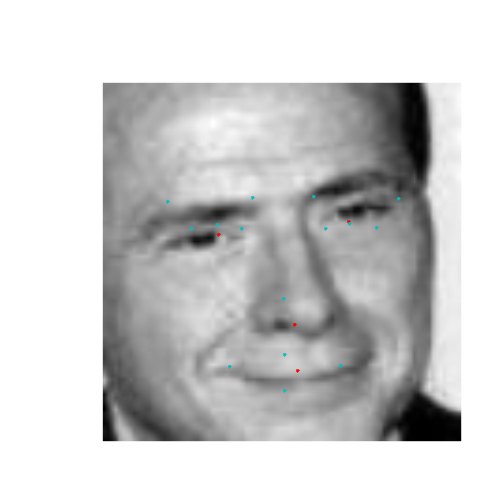

In [61]:
id = 1732
plot(X_t[id],y_hat1[id],y_hat2[id])

Regular NN with 1 hidden layer

In [40]:
net0 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

net0.fit(np.array(X_group.items()[big_group[-2]][1]), y2)


  input             	(None, 9216)        	produces    9216 outputs
  hidden            	(None, 100)         	produces     100 outputs
  output            	(None, 30)          	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.15862       0.04461      3.55589  0.22s
      2       0.02594       0.01587      1.63436  0.22s
      3       0.01414       0.01451      0.97502  0.21s
      4       0.01312       0.01314      0.99846  0.21s
      5       0.01196       0.01226      0.97551  0.21s
      6       0.01127       0.01171      0.96185  0.21s
      7       0.01078       0.01128      0.95568  0.21s
      8       0.01037       0.01092      0.95028  0.21s
      9       0.01003       0.01061      0.94543  0.21s
     10       0.00973       0.01034      0.94103  0.22s
     11       0.00947       0.01011      0.93697  0.22s
     12       0.00924       0.00991      0.93320  0.22s
     13       0.0

NeuralNet(X_tensor_type=<function matrix at 0x10a28e320>,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10b238590>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10b225850>,
     custom_score=None, eval_size=0.2, hidden_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
     objective_loss_function=<function mse at 0x10ae5e140>,
     on_epoch_finished=[<nolearn.lasagne.util.PrintLog instance at 0x11738be60>],
     on_training_finished=[], output_nonlinearity=None,
     output_num_units=30, regression=True,
     update=<function nesterov_momentum at 0x10ae5e848>,
     update_learning_rate=0.01, update_momentum=0.9,
     use_label_encoder=False, verbose=1,
     y

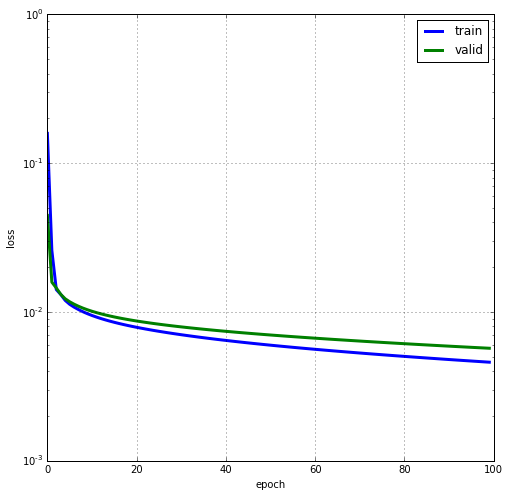

In [48]:
train_loss = np.array([i["train_loss"] for i in net0.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net0.train_history_])
# print train_loss
plt.figure(figsize=(8, 8))
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
# plt.ylim(1e-3, 1e-1)
plt.yscale("log")
plt.show()

In [10]:
filename='./save2.out'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        if key in ['y_hat1', 'y_hat2']:
            my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()
print 'Saving complete!'

Saving complete!


In [7]:
filename='./save1.out.db'
my_shelf = shelve.open(filename)
vNames = ""
for key in my_shelf:
    globals()[key]=my_shelf[key]
    vNames += key + ", "
my_shelf.close()
print 'loaded ' + vNames

loaded y_hat1, y_hat2, 
